读取数据

In [64]:
import pandas as pd
df = pd.read_csv('stock_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日期      1760 non-null   object 
 1   股票代码    1760 non-null   int64  
 2   开盘      1760 non-null   float64
 3   收盘      1760 non-null   float64
 4   最高      1760 non-null   float64
 5   最低      1760 non-null   float64
 6   成交量     1760 non-null   int64  
 7   成交额     1760 non-null   float64
 8   振幅      1760 non-null   float64
 9   涨跌幅     1760 non-null   float64
 10  涨跌额     1760 non-null   float64
 11  换手率     1760 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 165.1+ KB


把日期转换成时间格式并设置成索引，选取部分变量

In [65]:
columns = ['日期','开盘', '最高', '收盘', '最低', '成交量']
df['日期']=pd.to_datetime(df['日期'])
df = df[columns]
df.set_index('日期', inplace=True)

绘制一段时间内的K线图

2021-06-01 2021-09-30


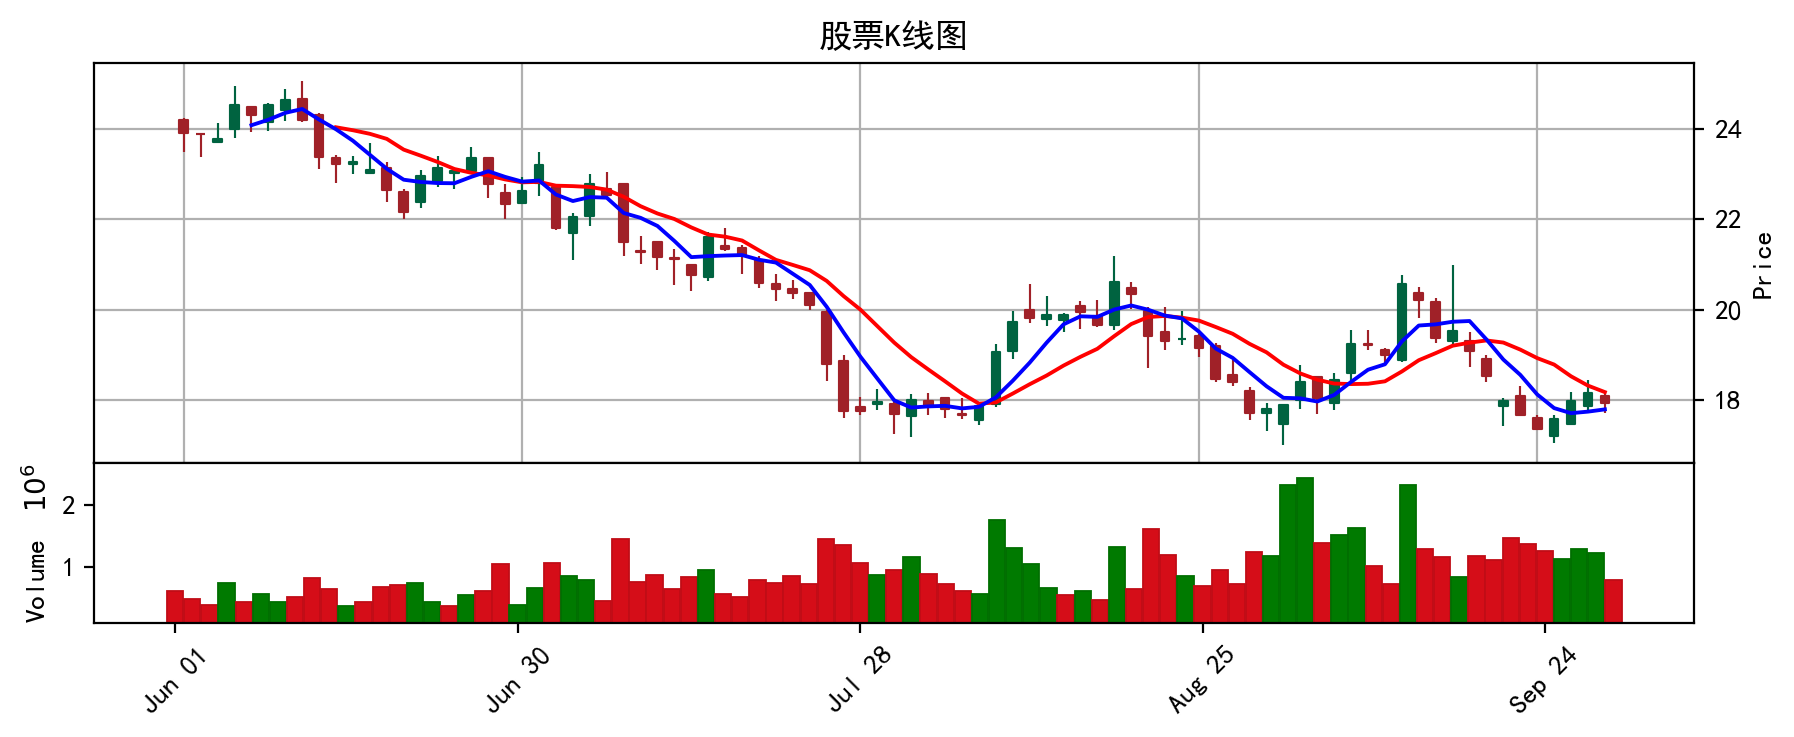

In [66]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

data = df.rename(columns={'开盘': 'open', '最高': 'high', '收盘': 'close', '最低': 'low', '成交量': 'volume'})

def kline(data,start_time,end_time):#绘制K线图
    print(start_time,end_time)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 处理数据
    data = data[start_time:end_time]

    # 添加图表
    global fig
    fig = plt.figure(figsize=(8, 4),dpi=200)
    ax = fig.add_axes([0,0.2,1,0.5])
    ax2 = fig.add_axes([0,0,1,0.2])
    # 绘制K线图
    mpf.plot(data,type='candle', style='charles', ax=ax, volume=ax2,mav=(10,5),mavcolors=('r','b'))

    ax.set_title("股票K线图")
    ax.grid(True)
    plt.show()

start_time = '2021-06-01'
end_time = '2021-09-30'
kline(data,start_time,end_time)

异常值处理和归一化并划分数据

In [67]:
for col in columns:
    if col == '日期':
        continue
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    outlier_condition = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))

    print(df[col][outlier_condition])

Series([], Name: 开盘, dtype: float64)
Series([], Name: 最高, dtype: float64)
Series([], Name: 收盘, dtype: float64)
Series([], Name: 最低, dtype: float64)
Series([], Name: 成交量, dtype: int64)


In [68]:
df.interpolate(method='time')

,开盘,最高,收盘,最低,成交量
日期,,,,,
2017-03-01,9.49,9.55,9.49,9.47,346994
2017-03-02,9.51,9.54,9.43,9.42,403629
2017-03-03,9.41,9.43,9.40,9.36,342655
2017-03-06,9.40,9.46,9.45,9.39,404511
2017-03-07,9.44,9.46,9.45,9.40,294673
...,...,...,...,...,...
2024-05-22,11.56,11.74,11.56,11.46,2115531
2024-05-23,11.53,11.59,11.40,11.37,1841623
2024-05-24,11.37,11.49,11.31,11.30,1398276


In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scalers = {}

for col in df.columns:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
    scalers[col] = scaler
print(df)

                  开盘        最高        收盘        最低       成交量
日期                                                          
2017-03-01  0.075733  0.073927  0.076349  0.086221  0.059304
2017-03-02  0.077362  0.073132  0.071369  0.081995  0.087389
2017-03-03  0.069218  0.064388  0.068880  0.076923  0.057153
2017-03-06  0.068404  0.066773  0.073029  0.079459  0.087826
2017-03-07  0.071661  0.066773  0.073029  0.080304  0.033359
...              ...       ...       ...       ...       ...
2024-05-22  0.244300  0.248013  0.248133  0.254438  0.936297
2024-05-23  0.241857  0.236089  0.234855  0.246830  0.800470
2024-05-24  0.228827  0.228140  0.227386  0.240913  0.580620
2024-05-27  0.223941  0.231320  0.243983  0.241758  0.608432
2024-05-28  0.239414  0.235294  0.234855  0.245985  0.484442

[1560 rows x 5 columns]


划分数据集

In [70]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [71]:
import numpy as np
def data_split(dataset, look_back=100):
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

X_train, y_train = data_split(train.values)
X_test, y_test = data_split(test.values)

定义神经网络

In [72]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, Input
from keras.optimizers import Nadam

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(
        filters=64,
        kernel_size=3,
        activation="relu"
    ),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(5)
])

model.compile(optimizer=Nadam(learning_rate=0.001), loss="mse")

开始训练模型

In [73]:
from keras.callbacks import EarlyStopping
#早停策略
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=[es]
)
model.save('股票数据预测.h5')

Epoch 1/20


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0465 - val_loss: 0.0184
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0173 - val_loss: 0.0165
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0147 - val_loss: 0.0111
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0142 - val_loss: 0.0096
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0131 - val_loss: 0.0097
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0119 - val_loss: 0.0087
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0118 - val_loss: 0.0087
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0117 - val_loss: 0.0088
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0116 - val_l

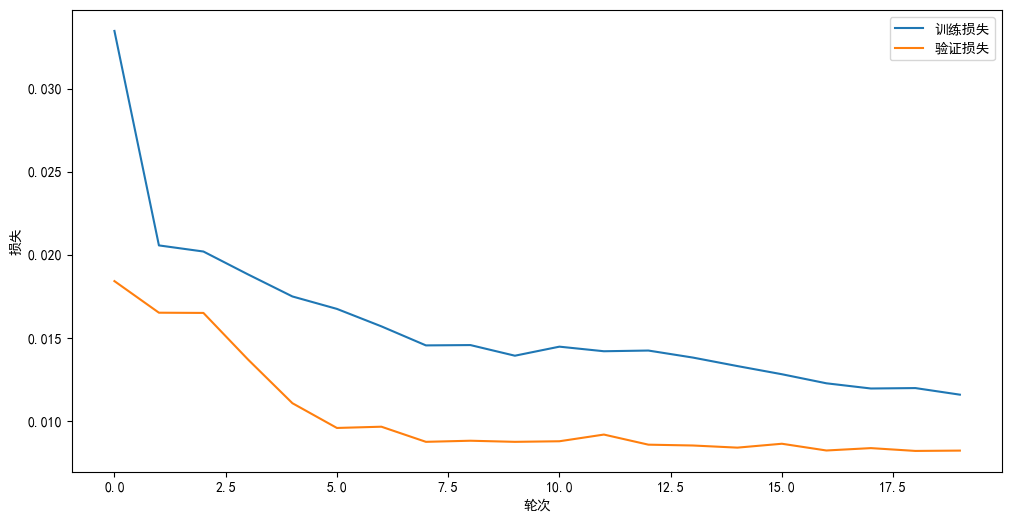

In [74]:
# 绘制训练损失和验证损失
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.legend()
plt.show()

进行反归一化

               开盘     最高     收盘     最低        成交量
日期                                               
2017-03-01   9.49   9.55   9.49   9.47   346994.0
2017-03-02   9.51   9.54   9.43   9.42   403629.0
2017-03-03   9.41   9.43   9.40   9.36   342655.0
2017-03-06   9.40   9.46   9.45   9.39   404511.0
2017-03-07   9.44   9.46   9.45   9.40   294673.0
...           ...    ...    ...    ...        ...
2024-05-22  11.56  11.74  11.56  11.46  2115531.0
2024-05-23  11.53  11.59  11.40  11.37  1841623.0
2024-05-24  11.37  11.49  11.31  11.30  1398276.0
2024-05-27  11.31  11.53  11.51  11.31  1454361.0
2024-05-28  11.50  11.58  11.40  11.36  1204323.0

[1560 rows x 5 columns]
2021-06-01 2021-09-30


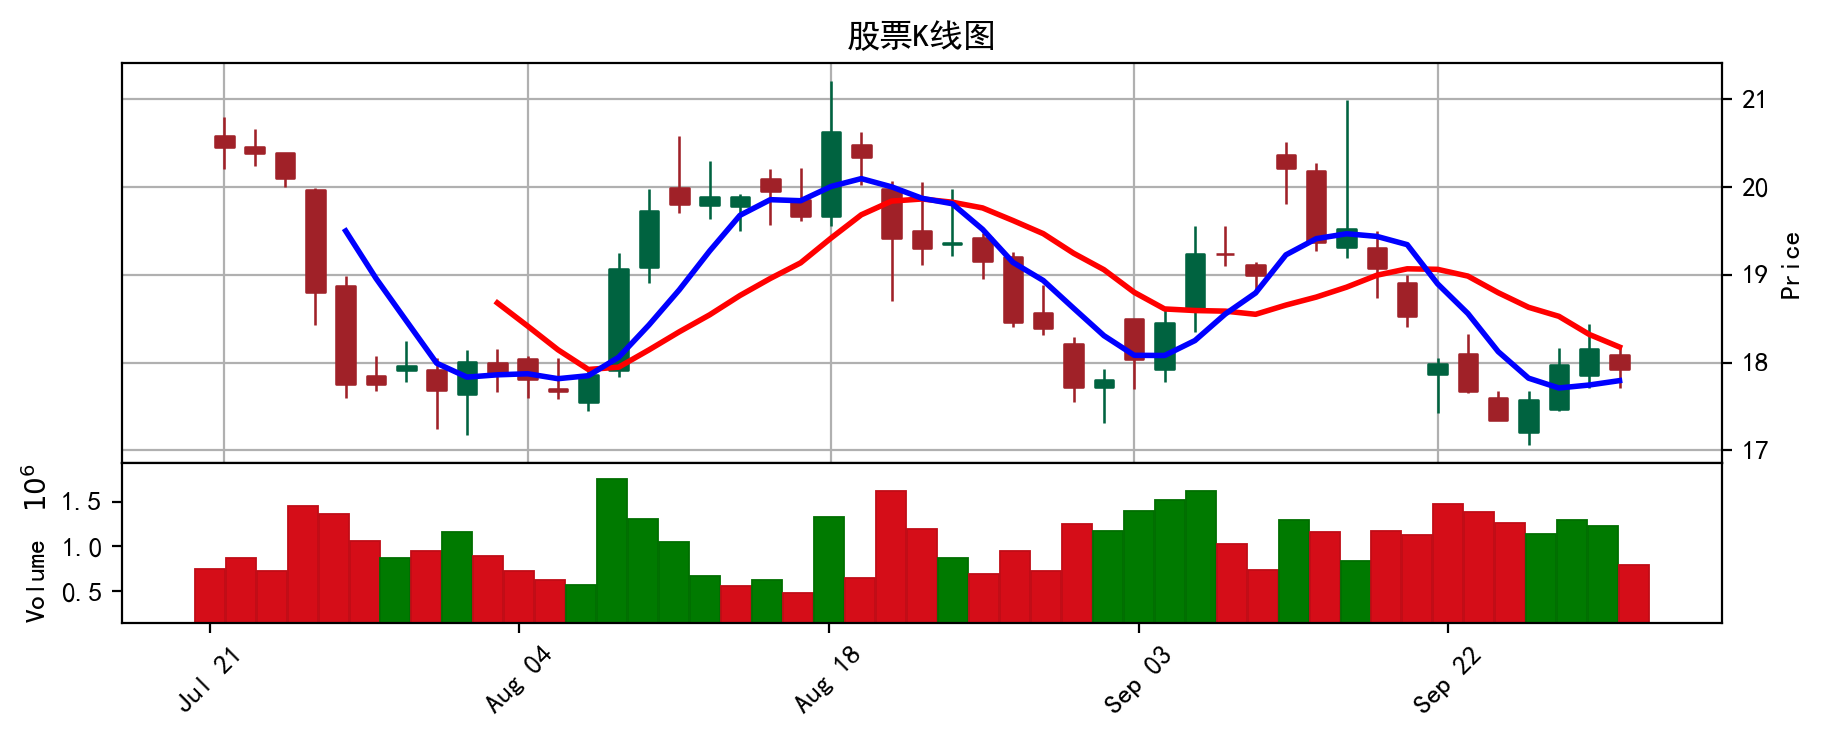

2021-06-01 2021-09-30


In [75]:
def inverse_scaling(df, scalers):
    #归一化数据逆缩放
    df_inverse = pd.DataFrame()
    for col in df.columns:
        df_inverse[col] = scalers[col].inverse_transform(df[col].values.reshape(-1, 1)).flatten()
    return df_inverse

df_inverse = inverse_scaling(df, scalers)
df_inverse['日期'] = df.index
df_inverse.set_index('日期', inplace=True)
print(df_inverse)#原数据
df_inverse = df_inverse.rename(columns={'开盘': 'open', '最高': 'high', '收盘': 'close', '最低': 'low', '成交量': 'volume'})
kline(df_inverse,start_time,end_time)
print(start_time,end_time)

前面的步骤：
1.读取数据
2.进行数据预处理，包括异常值、缺失值处理和归一化
3.分割数据成训练集和测试集
4.把数据的60天的时间步放到了X_train和X_test
5.定义模型的参数和神经网络
6.使用包含时间步的数据进行模型训练

希望使用的模型步骤
模型接受数据类型：
(样本量，时间步长为60的数据，维度为5)
通过包含前六十天的数据预测明天的数据
把明天的数据加到原数据，通过包含前五十九天的数据和明天的数据来预测后天的数据

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
        开盘     最高     收盘     最低        成交量
0    11.30  11.30  11.18  11.15   676577.0
1    11.20  11.32  11.28  11.17   461702.0
2    11.28  11.33  11.30  11.22   365396.0
3    11.29  11.29  11.18  11.17   485906.0
4    11.18  11.31  11.23  11.15   519053.0
..     ...    ...    ...    ...        ...
206  11.32  11.62  11.55  11.31  2030049.0
207  11.56  11.74  11.56  11.46  2115531.0
208  11.53  11.59  11.40  11.37  1841623.0
209  11.37  11.49  11.31  11.30  1398276.0
210  11.31  11.53  11.51  11.31  1454361.0

[211 rows x 5 columns]
           开盘        最高        收盘        最低           成交量
0    147.3240  150.7740  143.2890  140.3545  1.364381e+12
1    146.0960  151.0256  144.4940  140.5911  9.310652e+11
2    147.0784  151.1514  144.7350  141.1826  7.368552e+11
3    147.2012  150.6482  143.2890  140.5911  9.798749e+11
4    145.8504  150.8998  143.8915  140.3545  1.046719e+12
..        ...       ...       ...       ...           ...
206  147.5696  

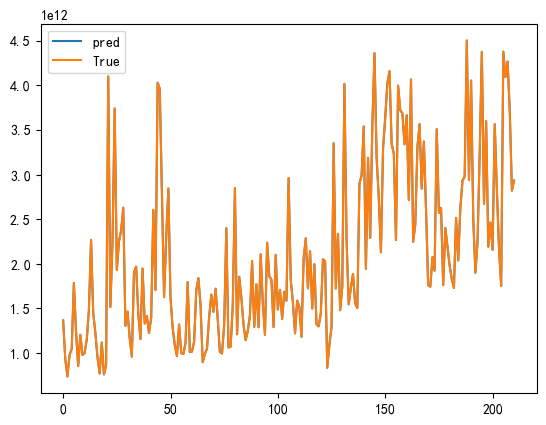

In [82]:
def predict(X, y, scalers):
    # 预测
    y_pred = model.predict(X)
    y_pred = pd.DataFrame(y_pred, columns=y.columns)
    y_pred = inverse_scaling(y_pred, scalers)
    y_true = inverse_scaling(y, scalers)
    return y_pred, y_true
y_pred,y_true= predict(X_train, pd.DataFrame(y_test, columns=test.columns), scalers)
# 创建一个新的图表
plt.figure()

y_pred = y_pred[:y_test.shape[0]]
y_test

test=y_pred - y_test
print(y_pred)
plt.plot(y_pred.index, y_true['成交量'], label='pred')
plt.plot(y_test.index, y_test['成交量'], label='True')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [77]:
# # 选择 X_train 的最后一部分作为输入数据
# last_part = X_train[-1]
# last_part = np.expand_dims(last_part, axis=0)

# def predict_data(last_part, days=90):
#     #已知数据(样本数，时间步长，特征数)
#     future = []
#     for _ in range(days):
#         next_day = model.predict(last_part,verbose=0)
#         #格式是(1, 5)，一天的五个变量
#         future.append(next_day)
#         #所以把该变量和last_part合并，并删除last_part的第一个时间步长
#         #lastpart为(样本数，时间步长，特征数)
#         #next_day为(样本数，特征数)
#         next_day = np.expand_dims(next_day, axis=1)  # 增加一个新的维度
#         last_part = np.concatenate((last_part[:, 1:, :], next_day), axis=1) 
#     future = np.squeeze(future, axis=1)
#     future_df = pd.DataFrame(future, columns=['开盘', '最高', '收盘', '最低', '成交量'])
#     return future_df

# days = y_test.shape[0]
# future = predict_data(last_part, days=days)

# future=inverse_scaling(future,scalers)
# future['日期'] = df.index[-days:]
# future.set_index('日期', inplace=True)
# print(future)

future为预测数据，将其和X_test进行可视化分析

In [78]:
start_time = '2023-06-27'
end_time = '2023-09-30'

print(start_time,end_time)
future=future.rename(columns={'开盘': 'open', '最高': 'high', '收盘': 'close', '最低': 'low', '成交量': 'volume'})
kline(future,start_time,end_time)
kline(data,start_time,end_time)

# 计算两个 DataFrame 的差值
future = future[start_time:end_time]
data = data[start_time:end_time]
diff = future - data

# 计算每个数据点的误差
error = diff.abs()

# 计算平均误差
mean_error = error.var()
print(error)

print(mean_error)

2023-06-27 2023-09-30


NameError: name 'future' is not defined